# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import seaborn as sns
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

df_eda = df.copy()
df_eda = df_eda.replace('?', np.nan)

df_eda.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [4]:
def count_unique_values(df, cat_col_list):
    cat_df = df[cat_col_list]
    val_df = pd.DataFrame({'columns': cat_df.columns, 
                       'cardinality': cat_df.nunique() } )
    return val_df

In [5]:
categorical_feature_list = [ 'encounter_id', 'patient_nbr']
val_df = count_unique_values(df_eda, categorical_feature_list) 
print(val_df)
print(len(df_eda.index))


                   columns  cardinality
encounter_id  encounter_id       101766
patient_nbr    patient_nbr        71518
143424


Student Response: There are more encounters than patients which makes sense for patients to have multiple encounters. There are also more encounters than rows so the detail right now is at the line level.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

In [6]:
def check_null_values(df):
    null_df = pd.DataFrame({'columns': df.columns, 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                           'percent_zero': df.isin([0]).sum() * 100 / len(df)
                           } )
    return null_df 

null_df = check_null_values(df_eda)
null_df

,columns,percent_null,percent_zero
encounter_id,encounter_id,0.000000,0.000000
patient_nbr,patient_nbr,0.000000,0.000000
race,race,2.307145,0.000000
gender,gender,0.000000,0.000000
age,age,0.000000,0.000000
weight,weight,97.000502,0.000000
admission_type_id,admission_type_id,0.000000,0.000000
discharge_disposition_id,discharge_disposition_id,0.000000,0.000000
admission_source_id,admission_source_id,0.000000,0.000000
time_in_hospital,time_in_hospital,0.000000,0.000000


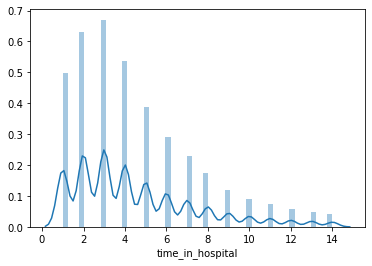

In [7]:
sns.distplot(df_eda['time_in_hospital'])

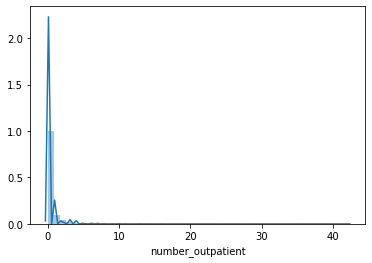

In [8]:
sns.distplot(df_eda['number_outpatient'])

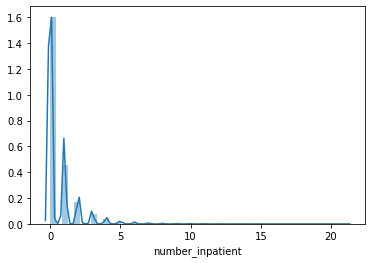

In [9]:
sns.distplot(df_eda['number_inpatient'])

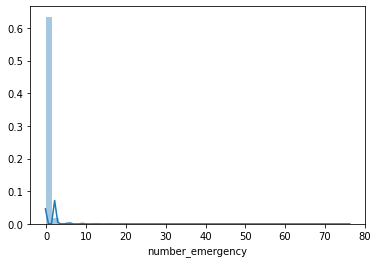

In [10]:
sns.distplot(df_eda['number_emergency'])

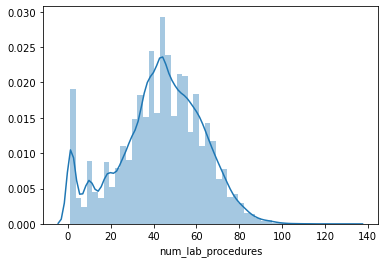

In [11]:
sns.distplot(df_eda['num_lab_procedures'])

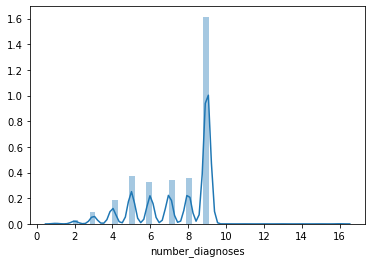

In [12]:
sns.distplot(df_eda['number_diagnoses'])

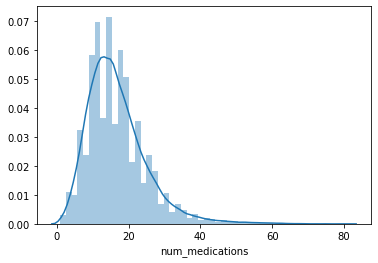

In [13]:
sns.distplot(df_eda['num_medications'])

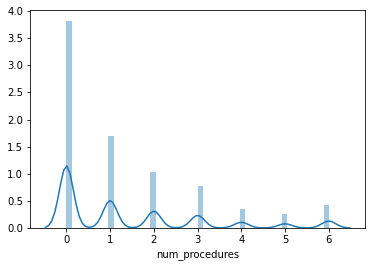

In [14]:
sns.distplot(df_eda['num_procedures'])

In [15]:
def count_unique_values(df, cat_col_list):
    cat_df = df[cat_col_list]
    val_df = pd.DataFrame({'columns': cat_df.columns, 
                       'cardinality': cat_df.nunique() } )
    return val_df

In [16]:
categorical_feature_list = [ 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code', 'max_glu_serum', 'A1Cresult', 'change']
val_df = count_unique_values(df_eda, categorical_feature_list) 
val_df

,columns,cardinality
race,race,5
gender,gender,3
age,age,10
admission_type_id,admission_type_id,8
discharge_disposition_id,discharge_disposition_id,26
admission_source_id,admission_source_id,17
payer_code,payer_code,17
medical_specialty,medical_specialty,72
primary_diagnosis_code,primary_diagnosis_code,716
other_diagnosis_codes,other_diagnosis_codes,19374


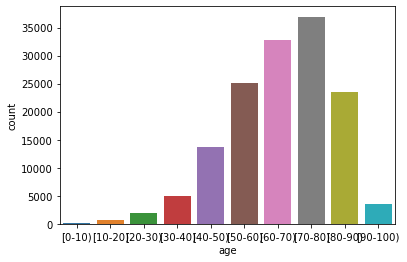

In [17]:
ax = sns.countplot(x="age", data=df_eda)

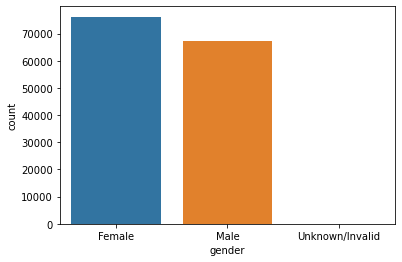

In [18]:
ax = sns.countplot(x="gender", data=df_eda)

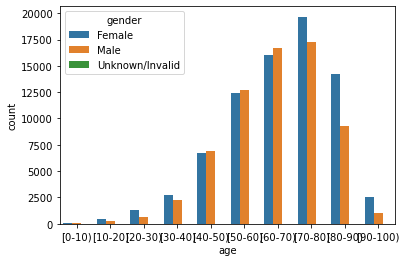

In [19]:
ax = sns.countplot(x="age", hue="gender", data=df_eda)

**Student Response**: 
a. Fields with missing / zero values  
  *race* has 2.3% of data with null data. These are likely missing values from the data.  
  *weight* has 97% of the data with null data. This is likely that data set did not regularly collect the data and the column should not be used for selection/analysis. 
  *payer_code* has 37.8% of data with null data. This is likely that the data was only sporadically collected from some encounters. This makes it likely we should not use this column for selection/analysis.
*medical_specialty*	has 48.4% of the data with null values. This means a lot of the data was collected but nearly half was not collected.
*primary_diagnosis_code* has .02% of data with null data. This is likely a small error in the data and if we use the primary_diagnosis_code we could just remove the rows with missing values.
 *number_outpatient* has 83.7% of data with zero. - Number of outpatient visits in prior year makes sense to have zero as a valid data element.  
*number_inpatient* has 67.4% of the data with zero. - Number of inpatient visits in prior year makes sense to have zero as a valid data element.  
*number_emergency* has 88.8% of the data with zero. - Number of emergency visits in prior year makes sense to have zero as a valid data element.  
*num_procedures* has 45.9% of data with zero. - This is the number of procedures besides labs performed in a visit. This makes sense to have zero as a valid data element.  
*ndc_code* has 16.4% of the data having null values. - This is likely missing data or random failure to collect data. 

b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?  
  Graphing all numerical fields above, the following fields have normal distribution shapes.
  *time_in_hospital*  
  *num_lab_procedures*
  *num_medications*

c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)  
  The following have high cardinaity  
  *medical_speciality* - The data schema indicates there are 84 recognized distinct values. 72 of which are appearing in this dataset.  
  *primary_diagnosis_code* - Contains ICD9 - CM code set which there are hundreds of diagnosis codes. The current code set has over [13,000 codes](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3865615/#:~:text=The%20current%20ICD%2D9%2DCM,and%20has%20flexibility%20for%20expansion.)
  *other_diagnosis_codes* - Contains up to two ICD9 - CM codes separated with a pipe delimiter allowing for a max possible number of codes of ~13,000 * ~13,000 = 169,000,000. It's not surprising then to see the ratio in the data set between primary_diagnosis_code (716) to other_diagnosis_code (19,374)
  *ndc_code	ndc_code* - per the data schema there are up to 270 potential ndc_codes and [this file](https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv) describes each ndc_code.


d. Please describe the demographic distributions in the dataset for the age and gender fields.    
  Age distribution follows a gaussian (normal) distribution centered on 70-80 year olds and trailing left slower than right of the center of the distribution.
  The distribution of male and female is fairly even with female being a slightly smaller part of the data set but not enough to be concerned about skewing the data.  
  The distribution of age/gender follows the same above trends per age bucket. The gaussian distribution is preserved with less female than male. In the 40-50, 50-60, and 60-70 age buckets female slightly outnumbers male records. The only concerning data point is 80-90 where there is about 1/3 less female records than male records.

In [22]:
######NOTE: The visualization will only display in Chrome browser. ########
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [43]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [44]:
from student_utils import reduce_dimension_ndc

In [45]:
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [46]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
reduce_dim_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143477,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,38,590|296,1,0,0,53,13,9,0,47918-902,None,None,Ch,NO,Insulin Human
143478,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0049-4110,None,None,Ch,NO,Glipizide
143479,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0781-5421,None,None,Ch,NO,Pioglitazone
143480,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,47918-902,None,None,Ch,NO,Insulin Human


In [48]:
print(df['ndc_code'].nunique())
print(reduce_dim_df['generic_drug_name'].nunique())

#print(len(df.index))
#print(len(reduce_dim_df.index))

251
22


In [49]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [50]:
from student_utils import select_first_encounter

In [51]:
print(len(reduce_dim_df))

def select_first_one(df):
    df = df.sort_values("encounter_id")
    last_encounter_values = df.groupby("patient_nbr")["encounter_id"].head(1).values
    return df[df["encounter_id"].isin(last_encounter_values)]

first_encounter_df = select_first_one(reduce_dim_df)
print(len(first_encounter_df))

143482
101794


In [52]:
reduce_dim_df[reduce_dim_df['patient_nbr']==31693671]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
84929,171362400,31693671,Caucasian,Female,[80-90),?,1,22,7,6,MC,Emergency/Trauma,820,424|250.02,0,0,0,59,4,19,3,0049-4110,None,>7,Ch,>30,Glipizide
84930,171362400,31693671,Caucasian,Female,[80-90),?,1,22,7,6,MC,Emergency/Trauma,820,424|250.02,0,0,0,59,4,19,3,0378-0318,None,>7,Ch,>30,Pioglitazone
84931,171362400,31693671,Caucasian,Female,[80-90),?,1,22,7,6,MC,Emergency/Trauma,820,424|250.02,0,0,0,59,4,19,3,47918-898,None,>7,Ch,>30,Insulin Human
103888,220587978,31693671,Caucasian,Female,[80-90),?,2,3,7,8,MC,Emergency/Trauma,428,424|414,0,1,0,60,6,10,0,0591-0460,None,>8,Ch,>30,Glipizide
103889,220587978,31693671,Caucasian,Female,[80-90),?,2,3,7,8,MC,Emergency/Trauma,428,424|414,0,1,0,60,6,10,0,47918-902,None,>8,Ch,>30,Insulin Human
115511,255395892,31693671,Caucasian,Female,[80-90),?,2,2,7,5,MC,Emergency/Trauma,428,424|53,0,1,0,52,9,15,3,0049-4120,None,None,Ch,>30,Glipizide
115512,255395892,31693671,Caucasian,Female,[80-90),?,2,2,7,5,MC,Emergency/Trauma,428,424|53,0,1,0,52,9,15,3,0378-0228,None,None,Ch,>30,Pioglitazone
115513,255395892,31693671,Caucasian,Female,[80-90),?,2,2,7,5,MC,Emergency/Trauma,428,424|53,0,1,0,52,9,15,3,47918-902,None,None,Ch,>30,Insulin Human
143478,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0049-4110,None,None,Ch,NO,Glipizide
143479,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0781-5421,None,None,Ch,NO,Pioglitazone


In [53]:
first_encounter_df[first_encounter_df['patient_nbr']==31693671]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
84929,171362400,31693671,Caucasian,Female,[80-90),?,1,22,7,6,MC,Emergency/Trauma,820,424|250.02,0,0,0,59,4,19,3,0049-4110,None,>7,Ch,>30,Glipizide
84930,171362400,31693671,Caucasian,Female,[80-90),?,1,22,7,6,MC,Emergency/Trauma,820,424|250.02,0,0,0,59,4,19,3,0378-0318,None,>7,Ch,>30,Pioglitazone
84931,171362400,31693671,Caucasian,Female,[80-90),?,1,22,7,6,MC,Emergency/Trauma,820,424|250.02,0,0,0,59,4,19,3,47918-898,None,>7,Ch,>30,Insulin Human


In [54]:
first_encounter_df = select_first_encounter(reduce_dim_df)

In [55]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [56]:
exclusion_list = ['generic_drug_name', 'ndc_code']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [62]:
print(len(agg_drug_df))
print(agg_drug_df['patient_nbr'].nunique())
print(agg_drug_df['encounter_id'].nunique())

assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

print(agg_drug_df)

71518
71518
71518
       encounter_id  patient_nbr             race  gender       age weight  \
0             12522     48330783        Caucasian  Female   [80-90)      ?   
1             15738     63555939        Caucasian  Female  [90-100)      ?   
2             16680     42519267        Caucasian    Male   [40-50)      ?   
3             28236     89869032  AfricanAmerican  Female   [40-50)      ?   
4             35754     82637451        Caucasian    Male   [50-60)      ?   
...             ...          ...              ...     ...       ...    ...   
71513     443842016    183087545        Caucasian  Female   [70-80)      ?   
71514     443842022    188574944            Other  Female   [40-50)      ?   
71515     443842070    140199494            Other  Female   [60-70)      ?   
71516     443842340    120975314        Caucasian  Female   [80-90)      ?   
71517     443867222    175429310        Caucasian    Male   [70-80)      ?   

       admission_type_id  discharge_dispositi

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: Weight has 97% null data and is effectively unusable with such a small amount of populated data. The payer_code has 37.8% null data. This is high enough that we cannot easily remove the records with null from the data set nor use the available codes as the model would be skewed to all the missing data.


In [63]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = [ "admission_type_id", "admission_source_id", "discharge_disposition_id", "primary_diagnosis_code", "other_diagnosis_codes", "max_glu_serum", "A1Cresult", "readmitted" ] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ["number_diagnoses", "num_medications", "num_procedures" ]
PREDICTOR_FIELD = 'time_in_hospital'

In [64]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [65]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [66]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [67]:
from student_utils import patient_dataset_splitter

#key = 'patient_nbr'
#df = processed_df

d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

Total Count 71518
Sample Size 42911
Test Size 14304
Total number of unique patients in train =  42911
Total number of unique patients in test =  14304
Total number of unique patients in test =  14303
Training partition has a shape =  (42911, 37)
Test partition has a shape =  (14304, 37)
Validation partition has a shape =  (14303, 37)


In [68]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [69]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2919
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


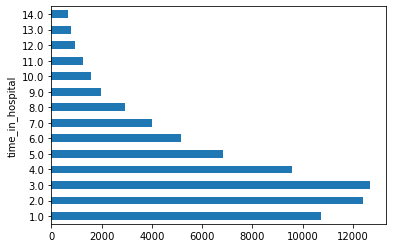

In [70]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6385
2.0     7517
3.0     7612
4.0     5730
5.0     4069
6.0     3101
7.0     2421
8.0     1742
9.0     1166
10.0     932
11.0     765
12.0     555
13.0     491
14.0     425
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


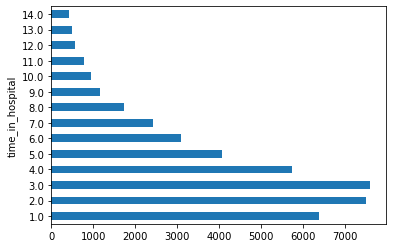

In [71]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2173
2.0     2396
3.0     2558
4.0     1907
5.0     1346
6.0     1040
7.0      798
8.0      588
9.0      405
10.0     337
11.0     246
12.0     221
13.0     156
14.0     133
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


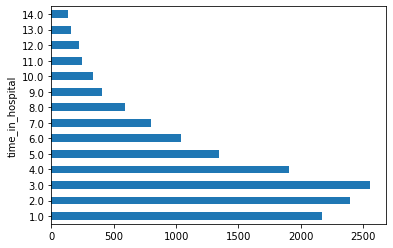

In [72]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             38025
Male               33490
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


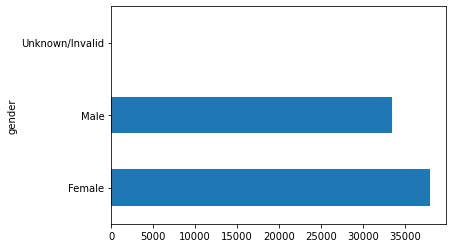

In [73]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             22902
Male               20007
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


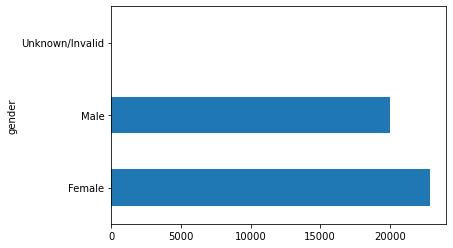

In [74]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female             7624
Male               6679
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


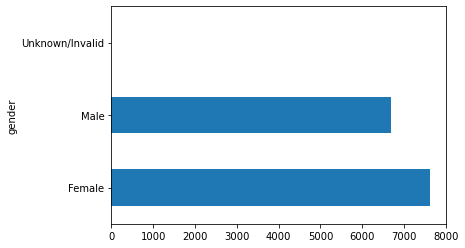

In [75]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [76]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [77]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [78]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [79]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

c:  admission_type_id
vocab_file_path: ./diabetes_vocab/admission_type_id_vocab.txt
INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
c:  admission_source_id
vocab_file_path: ./diabetes_vocab/admission_source_id_vocab.txt
INFO:tensorflow:vocabulary_size = 18 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.
c:  discharge_disposition_id
vocab_file_path: ./diabetes_vocab/discharge_disposition_id_vocab.txt
INFO:tensorflow:vocabulary_size = 27 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.
c:  primary_diagnosis_code
vocab_file_path: ./diabetes_vocab/primary_diagnosis_code_vocab.txt
INFO:tensorflow:vocabulary_size = 651 in primary_diagnosis_code is inferred from the number of elements in the vocabul

In [80]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=9, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(128, 10), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [81]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [82]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [83]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [84]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='number_diagnoses', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7fd684253050>, mean=7.244459462608655, std=1.9941397494698414))

tf.Tensor(
[[ 2.]
 [ 0.]
 [-2.]
 [ 2.]
 [-3.]
 [ 2.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [-2.]
 [ 1.]
 [ 2.]
 [-2.]
 [-2.]
 [ 2.]
 [ 2.]
 [-2.]
 [-2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 2.]
 [-2.]
 [ 2.]
 [ 2.]
 [-2.]
 [ 2.]
 [ 1.]
 [-3.]
 [ 2.]
 [-4.]
 [-3.]
 [-4.]
 [ 0.]
 [-1.]
 [-2.]
 [-1.]
 [ 2.]
 [ 1.]
 [-2.]
 [ 2.]
 [-1.]
 [ 2.]
 [ 2.]
 [ 0.]
 [-1.]
 [-2.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [-4.]
 [-2.]
 [-1.]
 [ 2.]
 [ 2.]
 [-1.]
 [ 2.]
 [ 2.]
 [-4.]
 [-3.]
 [ 2.]
 [ 2.]
 [-5.]
 [-1.]
 [ 0.]
 [-3.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 2.]
 [-1.]
 [ 2.]
 [ 2.]
 [ 0.]
 [ 2.]
 [-2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 2.]
 [-1.]
 [ 2.]
 [ 2.]
 [ 2.]
 [ 1.]
 [ 2.]
 [ 0.]
 [ 2.]
 [-1.]
 [ 2.]
 [ 2.]
 [ 2.

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [85]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [86]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [87]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=10)

Train for 336 steps, validate for 112 steps
Epoch 1/10
336/336 [==============================] - 23s 68ms/step - loss: 25.2850 - mse: 25.1520 - val_loss: 19.0291 - val_mse: 18.5414
Epoch 2/10
336/336 [==============================] - 18s 55ms/step - loss: 16.4292 - mse: 15.8144 - val_loss: 12.6194 - val_mse: 11.8454
Epoch 3/10
336/336 [==============================] - 18s 53ms/step - loss: 12.9256 - mse: 11.9949 - val_loss: 10.6735 - val_mse: 9.5966
Epoch 4/10
336/336 [==============================] - 19s 55ms/step - loss: 11.0188 - mse: 9.9995 - val_loss: 10.9299 - val_mse: 9.9518
Epoch 5/10
336/336 [==============================] - 18s 54ms/step - loss: 10.7012 - mse: 9.9114 - val_loss: 10.2959 - val_mse: 9.3836
Epoch 6/10
336/336 [==============================] - 19s 55ms/step - loss: 9.6002 - mse: 8.6714 - val_loss: 9.2613 - val_mse: 8.3436
Epoch 7/10
336/336 [==============================] - 19s 56ms/step - loss: 8.9269 - mse: 8.0748 - val_loss: 8.7095 - val_mse: 7.9531
Epo

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [88]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [89]:
from student_utils import get_mean_std_from_preds

#m = diabetes_yhat.mean()
#s = diabetes_yhat.stddev()

m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [90]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [91]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,9.215230,2.0,4.728989,0.703428
1,4.068401,2.0,3.333609,0.701608
2,5.022257,4.0,6.008240,0.703486
3,4.914611,3.0,6.232819,0.704863
4,1.713487,5.0,6.092536,0.703070


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [92]:
from student_utils import get_student_binary_prediction
#df = prob_output_df
#col = 'pred_mean'
#student_binary_prediction = df[col].apply(lambda x : 1 if x >= 5 else 0)
#print(student_binary_prediction)
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

0        0
1        0
2        1
3        1
4        1
        ..
14299    0
14300    1
14301    1
14302    1
14303    0
Name: pred_mean, Length: 14304, dtype: int64


### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [93]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [94]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,1882818,Female,Caucasian,2.0,0,0
1,40823784,Male,Caucasian,2.0,0,0
2,89309880,Male,Caucasian,4.0,1,0
3,120840161,Male,Caucasian,3.0,1,0
4,89405451,Female,Caucasian,5.0,1,1


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [96]:
# AUC, F1, precision and recall
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values

In [97]:
accuracy_score(y_true, y_pred)

0.6328998881431768

In [98]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.45      0.61      9034
           1       0.50      0.94      0.65      5270

    accuracy                           0.63     14304
   macro avg       0.71      0.70      0.63     14304
weighted avg       0.77      0.63      0.63     14304



In [99]:
roc_auc_score(y_true, y_pred)

0.6969632117167319

# Summary

Precision and recall are often used to evaluate a model.

Precision is the number of true positive predictions (where we predicted true and the value should have been true) divided by all positive predictions (both true and fale positive predictions). Precision gives us a measure of right ratio of really right predicitions to all right predictions. A high precision means the model is good at identifying positive cases well.

Recall is the number of true positive predictions divided by true positive plus false negative (where the model should have been positive but predicted negative). Recall gives us an indication if the model is mis-predicting positive.

Precision and recall generally work against each other where the more one changes, the other changes in the opposite direction. This is because we can create more precision but at the cost of higher false positives which impact recall. Or we can reduce false positives which impacts precision because there are less positive predictions. The F1 score is often used as a balance between these two factors where both measures are equally important. (Some models may optimize to recall like for medical screening where a false negative could be very bad like not identifying cancer).

This model is trying to balance the prediction of a short hospital stay vs. longer and hence it is important that precision and recall are both balanced. Overall maximizing the F1 score means balancing between precision and recall. This model shows an F1 score of .63 for all prediction classes which means roughly the success rate of identifying true positive and true negative results for each class.

In [101]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.45      0.61      9034
           1       0.50      0.94      0.65      5270

    accuracy                           0.63     14304
   macro avg       0.71      0.70      0.63     14304
weighted avg       0.77      0.63      0.63     14304



As can been seen digging into the numbers the precision for a longer stay (1) and the recall for a shorter stay (0) are both low .5 and .45. The model could use some significant improvements in those areas then the f1-score would rise significantly. The current model must not be exposing feature columns that help improve those two selection areas. Perhaps evaluating medications or additional available metrics in the dataset would improve the precicion of longer stays and the recall of shorter stays.

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [115]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

model_id, score_thresholds 1 {'rank_abs': [9893]}


In [116]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,9893,race,?,299,117,145,5,112,154,159,257,416,14304
1,1,binary 0/1,9893,race,AfricanAmerican,1833,787,907,55,732,926,981,1639,2620,14304
2,1,binary 0/1,9893,race,Asian,64,45,33,2,43,31,33,76,109,14304
3,1,binary 0/1,9893,race,Caucasian,7360,3253,3682,239,3014,3678,3917,6696,10613,14304
4,1,binary 0/1,9893,race,Hispanic,183,132,84,9,123,99,108,207,315,14304
5,1,binary 0/1,9893,race,Other,154,77,86,4,73,68,72,159,231,14304
6,1,binary 0/1,9893,gender,Female,5440,2184,2715,153,2031,2725,2878,4746,7624,14304
7,1,binary 0/1,9893,gender,Male,4453,2226,2222,161,2065,2231,2392,4287,6679,14304
8,1,binary 0/1,9893,gender,Unknown/Invalid,0,1,0,0,1,0,0,1,1,14304


In [117]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,?,0.97,0.44,0.04,0.48,0.56,0.03,0.96,0.52,0.03,0.72,0.38
1,race,AfricanAmerican,0.94,0.45,0.07,0.49,0.55,0.06,0.93,0.51,0.19,0.70,0.37
2,race,Asian,0.94,0.57,0.04,0.52,0.43,0.06,0.96,0.48,0.01,0.59,0.30
3,race,Caucasian,0.94,0.45,0.07,0.50,0.55,0.06,0.93,0.50,0.74,0.69,0.37
4,race,Hispanic,0.92,0.59,0.07,0.46,0.41,0.08,0.93,0.54,0.02,0.58,0.34
5,race,Other,0.94,0.46,0.05,0.56,0.54,0.06,0.95,0.44,0.02,0.67,0.31
6,gender,Female,0.95,0.43,0.07,0.50,0.57,0.05,0.93,0.50,0.55,0.71,0.38
7,gender,Male,0.93,0.48,0.07,0.50,0.52,0.07,0.93,0.50,0.45,0.67,0.36
8,gender,Unknown/Invalid,NaN,1.00,0.00,NaN,0.00,NaN,1.00,NaN,0.00,0.00,0.00


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [113]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male' }, 
                    alpha=0.05, 
                    check_significance=False)

f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

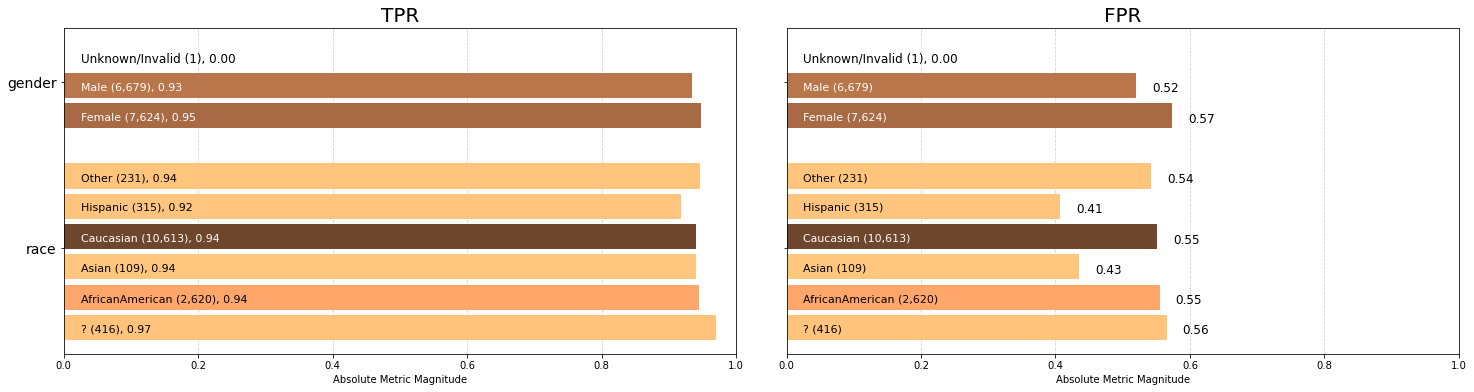

In [120]:
# Plot two metrics
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr'], ncols=2)



### Is there significant bias in your model for either race or gender?

For the true positive rate, there is little deviation. The model seems to not incorporate significant bias relative to race and gender for the true positive rate.

For the false positive rate there is a .05 differece between male and female but that seems to be acceptable. For race on the false positive rate there is some significant under reporting for hispanic and asian. They seem to have a significantly lower false positive rate that the base line caucasian race, (.55 - .43 =) .12 and (.55 - .41 =) .14 respectively. This indicates the model has some bias towards lower false positive rates for hispanics and asians. 

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

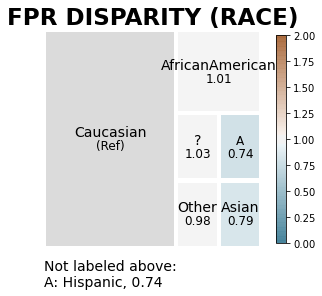

In [121]:
# Reference group fairness plot
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

The data here shows the same results better visualized for hispanics and asians relative to caucasians. The data shows a significant deviation of accurately predicting a longer hospitalization. The data shows hispanics and asians are less likely to be predicted to have longer hospitalizations. By about 26% less and 21% less respectively. This could indicate that race is a factor in the decision for how long a hospitalization stay should be.

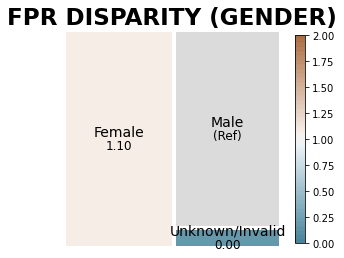

In [122]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

This data again shows that females are 10% more likely to be predicted to have a longer hospital stay than males. It is significant but not so far off that it is easily actionable data.